# Topic modeling for US petition data

In this poroject, I will experiment with the US petition data collected from We The People website. This data-set ranges from 2011-09-22 to 2016-09-29.  After removing non-English petitions and petitions with less than 50 words, we have 3672 rows available.

In [3]:
# read file, use serial as unique ids as all of the petitions have not-null values in this field
import pandas as pd
petitions = pd.read_csv("petitions.csv",error_bad_lines=False, warn_bad_lines=False)
petitions.shape

(3672, 8)

Although some rows were removed from the last step, we still have some rows where we have no Petition ID available. At this point, we will just removed these rows as we need the PIDs for our analysis. After this step, we will have 2802 rows available:

In [4]:
# only keep those rows where PID has 24 characters
# 219 petitions have no IDs or are note stored in the table in a standard way
mask = (petitions['PID'].str.len() == 24) 
petitions = petitions.loc[mask]
print petitions.shape

(2802, 8)


In [5]:
petitions.head()

,PID,title,body,pcreated,serial,signature_count,signature_threshold,status
0,4e7b35898d8c37d975000000,Grant voters the ability to vote for the Presi...,"The elections of 1824, 1876, 1888, and 2000 pr...",2011-09-22,6,29311,5000,Reviewed
1,4e7b3623709f036e7a000002,Reject the Keystone XL Pipeline,The proposed Keystone XL pipeline threatens ou...,2011-09-22,11,7875,5000,Reviewed
2,4e7b37f611fb9c1179000000,eliminate the permanent division of retention/...,The permanent division of retention/retirement...,2011-09-22,16,2542,5000,Closed
3,4e7b3ea34bd504e006000002,Change US policy to confront the government of...,"Recent events in Southern Kordofan, Blue Nile,...",2011-09-22,26,608,5000,Closed
4,4e7b3ea711fb9c3d7a000004,Fully Legalize Same-Sex Marriage Across The Na...,"Only 6 states, Connecticut, Iowa, Massachusett...",2011-09-22,31,17303,5000,Reviewed


Taking a close look at the number of signatures for every petition reveals that we are dealing with a exponential distribution with most of the petitions having less than 5000 signatures

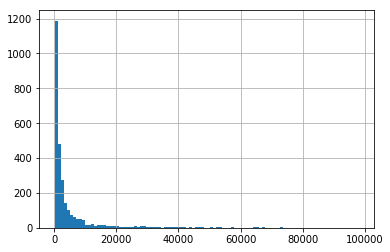

In [6]:
# explore
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
# convert non digit signature counts to NA values
petitions['signature_count'] = petitions['signature_count'] .apply(pd.to_numeric, args=('coerce',))
# signature cout distribution for count<100000
petitions.loc[petitions['signature_count']<100000,'signature_count'].hist(bins = 100)

# Train the Doc2Vec model

In this section, I will train a Doc2Vec model in order to embed every petition in a vector space. Doc2vec (aka paragraph2vec, aka sentence embeddings) modifies the word2vec algorithm to unsupervised learning of continuous representations for larger blocks of text, such as sentences, paragraphs or entire documents. Since the Doc2Vec class extends original Word2Vec class, many of the usage patterns are similar. One can easily adjust the dimension of the representation, the size of the sliding window, the number of workers, or almost any other parameter that you can change with the Word2Vec model.

The one exception to this rule are the parameters relating to the training method used by the model. In the word2vec architecture, the two algorithm names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the doc2vec architecture, the corresponding algorithms are “distributed memory” (dm) and “distributed bag of words” (dbow). Since the distributed memory model performed noticeably better in the paper, that algorithm is the default when running Doc2Vec. You can still force the dbow model if you wish, by using the dm=0 flag in constructor.

Before training the Doc2Vec model a number of pre-processing steps are requires. First, we will need to convert the encoding to utf-8. Then we will have to exclude punctuations and stopwords, do lemmartization or stemming, and make lists of separated words. We will then convert every word to lower case. After these steps, we will be able to train the Doc2Vec model.

In [ ]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
import numpy
from random import shuffle
from sklearn.linear_model import LogisticRegression
import string

# nlp processing functions
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# clean strings
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()
ignore_words = ["get","country","obama","without","right","government","president","cause","end","becomes","men","say","including","take","ask","stop","support","1","want","petition","american","united", "state","thousand", "since","even","million", "hour", "it" ,"could", "mr", "two", "every", "may","new","know", "good", "one", "many", "time", "need", "would", "way", "u", "year", "also", "day", "make", "made", "people", "use", "must", "found", "please", "help"]
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    lemmatized = " ".join(wordnet_lemmatizer.lemmatize(word) for word in punc_free.split())
    short_removed = " ".join([i for i in lemmatized.split() if len(i) > 2])
    freq_ignored = " ".join([i for i in short_removed.split() if i not in ignore_words])
    # stemmed = " ".join(porter_stemmer.stem(word) for word in lemmatized.split())
    return freq_ignored.split()

def LabeledLineSentence(doc,tag):
        return LabeledSentence(words=clean(doc), tags=[tag])
    
# define the Doc2Vec inputs
sentences = [LabeledLineSentence(i,j) for i,j in  zip(petitions['body'].tolist(),petitions['PID'].tolist())]

# generate the Doc2vec model
model = Doc2Vec(alpha=0.025, min_alpha=0.025, min_count=1, window=10, size=100, sample=1e-4, negative=5, workers=8)  # use fixed learning rate
model.build_vocab(sentences)

# train the model. You can increase range(200) to a higher number (e.g. range(500)) 
#and decrease alpha accordingly. It will improve your model but significantly 
#increase the computation time
for epoch in range(200):
    model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
    model.alpha -= 0.0001  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay
    
# save the model
model.save('./petitions.d2v')

In [9]:
# examine the doc2vec model

# model = Doc2Vec.load('./petitions.d2v')

#PID: 4e7b416e8d8c37da75000004 #doc_id: 5 #serial: 36
petition1 = """We the people want to know when we can have our "perfectly legitimate" discussion on marijuana 
legalization. Marijuana prohibition has resulted in the arrest of over 20 million Americans since 1965, 
countless lives ruined and hundreds of billions of tax dollars squandered and yet this policy has still 
failed to achieve its stated goals of lowering use rates, limiting the drug\'s access, and creating safer 
communities.\r\n\r\nIsn\'t it time to legalize and regulate marijuana in a manner similar to alcohol? If 
not, please explain why you feel that the continued criminalization of cannabis will achieve the results 
in the future that it has never achieved in the past? """

#PID: 4fa3ed1dcf436aef46000005 #doc_id: 344 #serial:2421
petition2 = """Currently all federal inmates have to serve a minimum of 85% of their sentence. Changing this 
requirement to 65% for all non-violent marijuana offenders would greatly reduce the injustice imposed by the 
harsh and unfair mandatory minimum laws. There are non-violent marijuana offenders serving more time then 
violent offenders, and this is a great injustice that needs to be corrected. This change would not leave the 
crime unpunished, but instead make the sentencing more suitable. This will allow individuals to return back 
to society quicker. Also, allow drug program 18 month reduction and 12 month half way house assignments to 
ensure better rehabilitation. It will reduce the enormous strain mandatory minimum sentences place on families 
and the America dollar. This change is long overdue."""

#PID: 52cde99c6ce61c8164000008 #doc_id: 1742 #serial: 11811
petition3 = """The federal government made $41.3 billion in profit on student loans in 2013. According to USA Today, that puts them just behind Exxon Mobile and Apple for having the most profitable 2013. The nation's student loan debt now surpasses auto loans and credit card debt yet the government has done nothing to address these issues. America deserves better. \r\n\r\nIn order for America to maintain its preeminence into the 21st century, it is essential that we incentivize our young people to attend college without worrying about financially jeopardizing their future. Therefore, we ask the government to make all student loan payments tax deductible. Enacting such legislation will reward those American who wish to attend college and responsibly pay off their loans, as payments will not be taxed as income."""

#PID: 55c38d1a00e579e708000000 #doc_id: 2923 #serial 20356
petition4 = """The public service student loan forgiveness program has been entered into in good faith by thousands of students who were promised loan forgiveness after 10 years in public service jobs. The program was created to encourage graduates to be willing to work in public sector jobs, such as  county attorneys, non profit positions, or state government jobs, which typically pay lower wages than private sector jobs, with the promise of loan forgiveness after 10 years of loan repayment under the program. The elimination of this program will create an immense financial burden on graduates who entered into the program as many as 8 years ago and have relied on the promise of loan forgiveness and took jobs at a lower salary than their peers."""

# we can now calculated the similarity (cosine) between these petitions
from gensim.models import Doc2Vec
import numpy
from numpy import dot
from numpy.linalg import norm

#model = Doc2Vec.load('./petitions.d2v')
def cos_sim(a,b): 
    a = model.docvecs[a] # a 1 star review
    b = model.docvecs[b]
    return dot(a, b)/(norm(a)*norm(b))

petition1 = "4e7b416e8d8c37da75000004" # drugs
petition2 = "4fa3ed1dcf436aef46000005" # drugs
petition3  = "52cde99c6ce61c8164000008" # education
petition4 = "55c38d1a00e579e708000000" # education
print cos_sim(petition1, petition2)
print cos_sim(petition1, petition3)
print cos_sim(petition2, petition3)
print cos_sim(petition1, petition4)
print cos_sim(petition2, petition4)
print cos_sim(petition3, petition4)

0.363028
0.213412
0.164851
0.299702
0.204562
0.299384


As we can see, the results makes sense. The similarity between the first and second petition (both about drugs) and the third and fourth petitions (both related to student loan) are significantly higher than other cases. In the next few steps, I will create a visualization where every petition is represented as a point. To this end, I will reduce the dimantions of every document resulted from Doc2Vec to two dimensions with X and Y coordinates. Although we will lose some information at this step, but it enables us to get a sense of petitions and their similarities.

In [10]:
# every point represents a petition. Points close to
# one naother represent those that are close in content. 
# you can hover over every point to see th epetition.

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [14]:
# generate coordinates for every petition using the first two principal components
import itertools 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
from pylab import rcParams

PIDs = petitions.PID.tolist()
text_body = petitions.body.tolist()

pets = []
for doc in PIDs:
    pets.append({'category': 'petitions', 'vec': model.infer_vector(doc)})
    
docs = [doc for doc in itertools.chain(pets)]

pca = PCA(n_components=50)
fiftyDimVecs = pca.fit_transform([doc['vec'] for doc in docs])
tsne = TSNE(n_components=2)
twoDimVecs = tsne.fit_transform(fiftyDimVecs)
tsne_vectors = pd.DataFrame(twoDimVecs)
tsne_vectors.columns = ['x_coord','y_coord']
tsne_vectors.index = text_body
tsne_vectors.head(2)

,x_coord,y_coord
"The elections of 1824, 1876, 1888, and 2000 produced an Electoral College winner who did not receive the plurality of the nationwide popular vote - that is, the American people did not get the President democracy should have selected.\r\n\r\nDue to the way electoral votes are allocated, candidates have a strong incentive to focus their campaigns on ""swing"" states with many voters, such as Florida, and neglect states such as Texas which do not swing. Due to necessary rounding errors when allocating votes, members of a sparsely populated state effectively accrue more voting power than members of a well-populated state. This increases the electoral power of members of certain states while reducing it for others on an ongoing basis.\r\n\r\nWe beg our leaders to dissolve this system and let us vote.",16.463982,12.198097
"The proposed Keystone XL pipeline threatens our water, our land, and our future. If permitted and constructed, the pipeline would further fuel the devastating extraction of tar sands in Alberta, and funnel highly toxic tar sands oil across the U.S.\r\n\r\nBig Oil has exploited the Canadian tar sands to great profit, but the environment and indigenous communities have paid a steep price.\r\n\r\nThe threat that pipeline spills pose to our land and water supplies is simply unacceptable. \r\n\r\nAdditionally, tar sands oil produces three times as much carbon pollution as conventional oil. We have a moral obligation to prevent the expansion of the tar sands and move towards a 100% clean energy future.\r\n\r\nPlease reject the Keystone XL permit and invest in real solutions to our climate and energy crisis.",38.395378,-12.785194


As we can see above, every petition is now represented with a x and y coordinate. We can now go ahead and visualize these points:

In [16]:
# add our DataFrame as a ColumnDataSource for Bokeh

plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@index') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);